In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MyDataset(Dataset):
    def __init__(self, feature_choice):
        current_dir = os.getcwd()

        data_paths = {
            "energies": os.path.join("data", "energies.npy"),
            "2-body": os.path.join("data", "features_2b.npy"),
            "3-body": os.path.join("data", "features_3b.npy"),
            "4-body": os.path.join("data", "features_4b.npy"),
            }
        if feature_choice == "2-body":
            features = np.load(data_paths["2-body"])
        elif feature_choice == "3-body":
            features = np.load(data_paths["3-body"])
        elif feature_choice == "4-body":
            features = np.load(data_paths["4-body"])
        elif feature_choice == "2+3-body":
            features_2 = np.load(data_paths["2-body"])
            features_3 = np.load(data_paths["3-body"])
            features = np.hstack((features_2, features_3))
        elif feature_choice == "4+3-body":
            features_4 = np.load(data_paths["4-body"])
            features_3 = np.load(data_paths["3-body"])
            features = np.hstack((features_4, features_3))
        elif feature_choice == "2+3+4-body":
            features_2 = np.load(data_paths["2-body"])
            features_3 = np.load(data_paths["3-body"])
            features_4 = np.load(data_paths["4-body"])
            features = np.hstack((features_2, features_3, features_4))
        else:
            raise ValueError("Invalid feature choice!")

        features = (features - features.mean())/features.std()
        self.features = features

        energies = np.load(data_paths["energies"])
        energies = (energies - energies.mean())/energies.std()
        self.targets = energies
        
        # Make sure both have the same length
        assert len(self.features) == len(self.targets), "Features and targets must have the same length"

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.features)
    
    def __getitem__(self, index):
        # Retrieve the features and target for the given index
        feature_row = self.features[index]  # Convert to numpy array
        target_value = self.targets[index]  # Convert to numpy array

        # Convert the features to a tensor
        features = torch.tensor(feature_row, dtype=torch.float32)
        
        # Convert the target to a tensor
        target = torch.tensor(target_value, dtype=torch.float32)
        
        return features, target

# Paths to your CSV files
features_file = 'data/features_2b.npy'
targets_file = 'data/energies.npy'

# Create dataset instance
dataset = MyDataset("2-body")

# Split the dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [3]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        
        # Define layers
        self.hidden = nn.Linear(input_size, hidden_size)  # Hidden layer
        self.relu = nn.ReLU()  # ReLU activation function
        self.output = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        # Pass input through the hidden layer, followed by ReLU
        x = self.relu(self.hidden(x))
        
        # Pass the result to the output layer
        x = self.output(x)
        
        return x

In [4]:
# Get the number of features in your dataset
input_size = dataset.features.shape[1]  # Number of features in your dataset
hidden_size = input_size  # Size of the hidden layer (you can change this)
output_size = 1  # For regression (single output), set this to 1

# Create the model instance
model = SimpleNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()  # Mean Squared Error Loss (for regression) should be1 RMSE / standard deviation in training set
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [5]:
# Training function
def train(model, dataloader, loss_fn, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        
        total_loss = 0
        
        for features, targets in dataloader:
            # Forward pass
            outputs = model(features)  # Forward pass through the network
            
            # Compute the loss
            loss = loss_fn(outputs.squeeze(), targets)  # Squeeze to match dimensions if needed
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            total_loss += loss.item()  # Accumulate loss for this batch
        
        #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}")


In [6]:
def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    
    predictions = []
    targets = []
    
    with torch.no_grad():  # Disable gradient computation
        for features, target in dataloader:
            output = model(features)  # Forward pass to get predictions
            predictions.append(output)
            targets.append(target)
    
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)

    loss = loss_fn(predictions.squeeze(), targets).item()
    return loss


In [7]:
from torch.utils.data import Subset
def simple_NN_graph(dataset, train_sizes = np.logspace(np.log10(0.01), np.log10(1), 8)):
    all_train_errors = []
    all_test_errors = []
    temp = 1
    for size in train_sizes:

        # Define the subsample size
        
        # Randomly generate unique indices for the subsample
        random_indices = np.random.choice(dataset.features.shape[0], int(size*dataset.features.shape[0]), replace=False)
        
        # Create a subset using the random indices
        subsample = Subset(dataset, random_indices)

        # Split the dataset        
        train_size = int(size* len(subsample) * 0.8)
        test_size = len(subsample) - train_size
        train_dataset, test_dataset = random_split(subsample, [train_size, test_size])
        
        # Create DataLoaders
        train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Get the number of features in your dataset
        input_size = dataset.features.shape[1]  # Number of features in your dataset
        hidden_size = input_size  # Size of the hidden layer (you can change this)
        output_size = 1  # For regression (single output), set this to 1
        
        # Create the model instance
        model = SimpleNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
        
        # Define the loss function and optimizer
        loss_fn = nn.MSELoss()  # Mean Squared Error Loss (for regression)
        optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

        #train model
        train(model, train_dataloader, loss_fn, optimizer, num_epochs=20)

        #train and test errors
        all_train_errors.append(evaluate(model, train_dataloader))
        all_test_errors.append(evaluate(model, test_dataloader))

        print(f"{temp}/8")
        temp = temp + 1


    all_train_errors = np.array(all_train_errors)
    all_test_errors = np.array(all_test_errors)
    np.save(f"train_errors_NN_2_3_body.npy", all_train_errors.T)
    np.save(f"test_errors_NN_2_3_body.npy", all_test_errors.T)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * dataset.features.shape[0], all_train_errors, marker = 'o', label="Training Error", color="r")
    plt.plot(train_sizes * dataset.features.shape[0], all_test_errors, marker = 'o', label="Testing Error", color="g")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Subset Size (Number of Training Samples)")
    plt.ylabel("Mean Squared Error")
    plt.title("Learning Curve for 2+3 body neural network with 1 hidden layer")
    plt.legend()
    plt.grid()
    plt.savefig("plots_nn/2_3_body.png")
    plt.show()

1/8
2/8
3/8
4/8
5/8
6/8
7/8
8/8


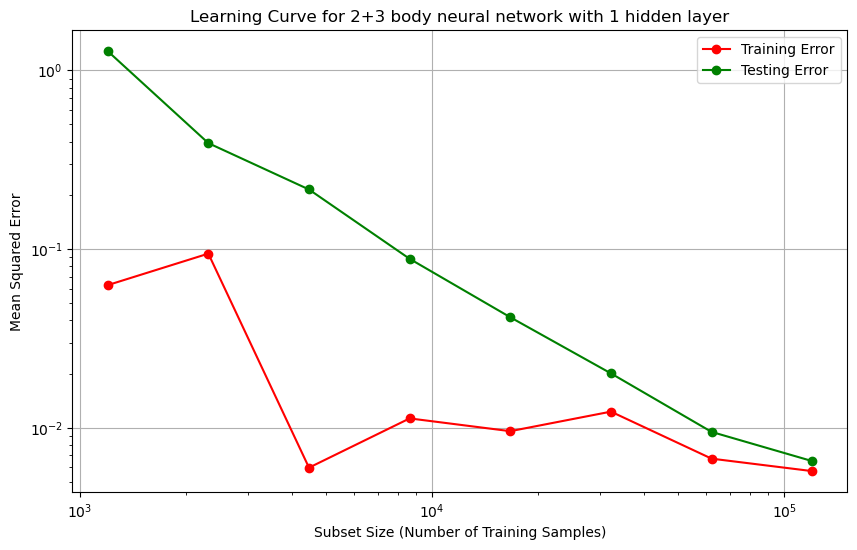

In [19]:
dataset = MyDataset("2+3-body")
simple_NN_graph(dataset)

In [8]:

class SimpleNN_multiple_layers(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden_layers, output_size):
        super(SimpleNN_multiple_layers, self).__init__()
        
        # Input layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Dynamically create hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden_layers)
        ])
        
        # Output layer
        self.output_layer = nn.Linear(hidden_size, output_size)
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the input layer and activation
        x = self.relu(self.input_layer(x))
        
        # Pass through each hidden layer with activation
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        
        # Pass through the output layer
        x = self.output_layer(x)
        
        return x

In [9]:
def NN_graph(dataset, hidden_layers= (np.logspace(0, 1, 4)).astype("int")):
    all_train_errors = []
    all_test_errors = []
    temp = 1
    print(hidden_layers)
    for hidden_layer in hidden_layers:
        # Define the subsample size
        # Randomly generate unique indices for the subsample
        random_indices = np.random.choice(dataset.features.shape[0], int(dataset.features.shape[0]), replace=False)

        # Split the dataset        
        train_size = int(dataset.features.shape[0] * 0.8)
        test_size = dataset.features.shape[0] - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
        
        # Create DataLoaders
        train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Get the number of features in your dataset
        input_size = dataset.features.shape[1]  # Number of features in your dataset
        hidden_size = 100  # Size of the hidden layer (you can change this)
        output_size = 1  # For regression (single output), set this to 1
        
        # Create the model instance
        model = SimpleNN_multiple_layers(input_size=input_size, hidden_size=hidden_size, n_hidden_layers = hidden_layer, output_size=output_size)
        
        # Define the loss function and optimizer
        loss_fn = nn.MSELoss()  # Mean Squared Error Loss (for regression)
        optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

        #train model
        train(model, train_dataloader, loss_fn, optimizer, num_epochs=40 + (20*hidden_layer))

        #train and test errors
        all_train_errors.append(evaluate(model, train_dataloader))
        all_test_errors.append(evaluate(model, test_dataloader))

        print(f"{temp}/4")
        temp = temp + 1


    all_train_errors = np.array(all_train_errors)
    all_test_errors = np.array(all_test_errors)
    np.save(f"train_errors_NN_3_body_multiple_hidden.npy", all_train_errors.T)
    np.save(f"test_errors_NN_3_body_multiple_hidden.npy", all_test_errors.T)

    plt.figure(figsize=(10, 6))
    plt.plot(hidden_layers, all_train_errors, marker = 'o', label="Training Error", color="r")
    plt.plot(hidden_layers, all_test_errors, marker = 'o', label="Testing Error", color="g")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Number of hidden layers")
    plt.ylabel("Mean Squared Error")
    plt.title("Learning Curve for 3 body neural network with varying number of hidden layers")
    plt.legend()
    plt.grid()
    plt.savefig("plots_nn/3_body_multiple_hidden.png")
    plt.show()


In [10]:
dataset = MyDataset("2-body")
NN_graph(dataset)

[ 1  2  4 10]
1/4


KeyboardInterrupt: 

In [30]:

def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, num_epochs=20, patience=10):
    best_val_loss = float('inf')  # Initialize with a large number
    epochs_without_improvement = 0  # Counter for early stopping
    best_epoch = 0  # To track which epoch had the best performance
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        
        total_loss = 0
        
        # Training loop
        for features, targets in train_dataloader:
            # Forward pass
            outputs = model(features)  # Forward pass through the network
            
            # Compute the loss
            loss = loss_fn(outputs.squeeze(), targets)  # Squeeze to match dimensions if needed
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            total_loss += loss.item()  # Accumulate loss for this batch
        
        # Compute average training loss
        avg_train_loss = total_loss / len(train_dataloader)
        
        # Evaluate on the validation set
        val_loss = evaluate(model, val_dataloader)  # Assume evaluate function calculates validation loss
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.5f}, Val Loss: {val_loss:.5f}")
        
        # Early stopping condition: if validation loss doesn't improve
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            epochs_without_improvement = 0
            # Save the best model's state_dict (weights)
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_without_improvement += 1
        
        # If no improvement for 'patience' epochs, stop training
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}, best epoch was {best_epoch+1}")
            break

    # Load the best model (with the lowest validation loss)
    model.load_state_dict(torch.load('best_model.pth'))
    
    # Return the best epoch and the corresponding validation loss
    return best_epoch, best_val_loss


In [31]:
def NN_graph(dataset, hidden_layers=(np.logspace(0, 1, 4)).astype("int"), patience=10):
    all_train_errors = []
    all_test_errors = []
    all_epochs = []
    temp = 1
    print(hidden_layers)

    for hidden_layer in hidden_layers:
        # Define the subsample size
        random_indices = np.random.choice(dataset.features.shape[0], int(dataset.features.shape[0]), replace=False)

        # Split the dataset        
        train_size = int(dataset.features.shape[0] * 0.8)
        test_size = dataset.features.shape[0] - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
        
        # Split further for validation (e.g., 80% training, 20% validation)
        train_size = int(len(train_dataset) * 0.8)
        val_size = len(train_dataset) - train_size
        train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
        
        # Create DataLoaders
        train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        input_size = dataset.features.shape[1]  # Number of features in your dataset
        hidden_size = 100  # Size of the hidden layer
        output_size = 1  # For regression (single output), set this to 1
        
        # Create the model instance
        model = SimpleNN_multiple_layers(input_size=input_size, hidden_size=hidden_size, n_hidden_layers=hidden_layer, output_size=output_size)
        
        # Define the loss function and optimizer
        loss_fn = nn.MSELoss()  # Mean Squared Error Loss (for regression)
        optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Adam optimizer

        # Train model with early stopping
        best_epoch, _ = train(model, train_dataloader, val_dataloader, loss_fn, optimizer, num_epochs=40 + (20 * hidden_layer), patience=patience)
        # Train and test errors
        all_train_errors.append(evaluate(model, train_dataloader))
        all_test_errors.append(evaluate(model, test_dataloader))
        all_epochs.append(best_epoch)

        print(f"{temp}/4")
        temp = temp + 1

    all_train_errors = np.array(all_train_errors)
    all_test_errors = np.array(all_test_errors)
    np.save(f"train_errors_NN_4_body_multiple_hidden.npy", all_train_errors.T)
    np.save(f"test_errors_NN_4_body_multiple_hidden.npy", all_test_errors.T)

    # Plotting the errors
    plt.figure(figsize=(10, 6))
    plt.plot(hidden_layers, all_train_errors, marker='o', label="Training Error", color="r")
    plt.plot(hidden_layers, all_test_errors, marker='o', label="Testing Error", color="g")

    # Annotate each point with the corresponding number of epochs
    for i, hidden_layer in enumerate(hidden_layers):
        plt.annotate(f'epochs: {all_epochs[i]}', 
                     (hidden_layers[i], all_train_errors[i]), 
                     textcoords="offset points", 
                     xytext=(0, 10), 
                     ha='center', fontsize=9)
        
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Number of hidden layers")
    plt.ylabel("Mean Squared Error")
    plt.title("Learning Curve for 4 body neural network with varying number of hidden layers")
    plt.legend()
    plt.grid()
    plt.savefig("plots_nn/4_body_multiple_hidden.png")
    plt.show()


[ 1  2  4 10]
Epoch 1/60, Train Loss: 0.37805, Val Loss: 0.10850
Epoch 2/60, Train Loss: 0.07073, Val Loss: 0.04540
Epoch 3/60, Train Loss: 0.03652, Val Loss: 0.02911
Epoch 4/60, Train Loss: 0.02499, Val Loss: 0.02185
Epoch 5/60, Train Loss: 0.01931, Val Loss: 0.01796
Epoch 6/60, Train Loss: 0.01595, Val Loss: 0.01540
Epoch 7/60, Train Loss: 0.01381, Val Loss: 0.01380
Epoch 8/60, Train Loss: 0.01233, Val Loss: 0.01256
Epoch 9/60, Train Loss: 0.01133, Val Loss: 0.01168
Epoch 10/60, Train Loss: 0.01050, Val Loss: 0.01095
Epoch 11/60, Train Loss: 0.00986, Val Loss: 0.01039
Epoch 12/60, Train Loss: 0.00933, Val Loss: 0.00998
Epoch 13/60, Train Loss: 0.00885, Val Loss: 0.00957
Epoch 14/60, Train Loss: 0.00847, Val Loss: 0.00944
Epoch 15/60, Train Loss: 0.00813, Val Loss: 0.00889
Epoch 16/60, Train Loss: 0.00780, Val Loss: 0.00864
Epoch 17/60, Train Loss: 0.00751, Val Loss: 0.00838
Epoch 18/60, Train Loss: 0.00725, Val Loss: 0.00818
Epoch 19/60, Train Loss: 0.00701, Val Loss: 0.00806
Epoch 2

/tmp/ipykernel_11887/3990698474.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


1/4
Epoch 1/80, Train Loss: 0.43069, Val Loss: 0.09521
Epoch 2/80, Train Loss: 0.06010, Val Loss: 0.03849
Epoch 3/80, Train Loss: 0.02992, Val Loss: 0.02380
Epoch 4/80, Train Loss: 0.02019, Val Loss: 0.01799
Epoch 5/80, Train Loss: 0.01589, Val Loss: 0.01521
Epoch 6/80, Train Loss: 0.01352, Val Loss: 0.01342
Epoch 7/80, Train Loss: 0.01201, Val Loss: 0.01245
Epoch 8/80, Train Loss: 0.01095, Val Loss: 0.01158
Epoch 9/80, Train Loss: 0.01017, Val Loss: 0.01114
Epoch 10/80, Train Loss: 0.00954, Val Loss: 0.01039
Epoch 11/80, Train Loss: 0.00902, Val Loss: 0.00975
Epoch 12/80, Train Loss: 0.00856, Val Loss: 0.00947
Epoch 13/80, Train Loss: 0.00818, Val Loss: 0.00913
Epoch 14/80, Train Loss: 0.00784, Val Loss: 0.00892
Epoch 15/80, Train Loss: 0.00753, Val Loss: 0.00908
Epoch 16/80, Train Loss: 0.00727, Val Loss: 0.00843
Epoch 17/80, Train Loss: 0.00700, Val Loss: 0.00818
Epoch 18/80, Train Loss: 0.00678, Val Loss: 0.00807
Epoch 19/80, Train Loss: 0.00657, Val Loss: 0.00778
Epoch 20/80, Trai

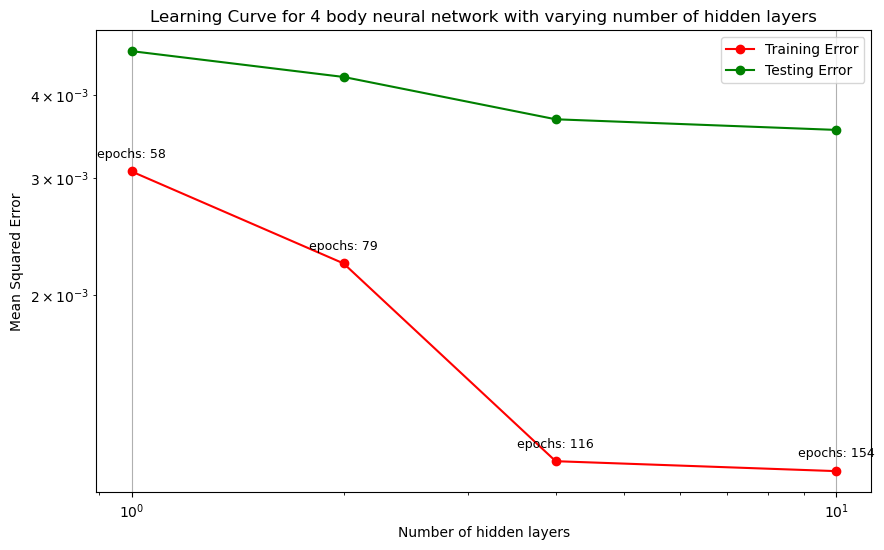

In [32]:
dataset = MyDataset("4-body")
NN_graph(dataset)

In [7]:
from torch.utils.data import Subset
def simple_NN_graph(dataset, hidden_sizes = np.array([10,50,100, 200, 500]), train_sizes=np.logspace(np.log10(0.01), np.log10(1), 8)):
    all_train_errors = []
    all_test_errors = []
    
    for hidden_size in hidden_sizes:
        train_errors_for_hidden_size = []
        test_errors_for_hidden_size = []

        temp = 1
        for size in train_sizes:
            # Define the subsample size
            random_indices = np.random.choice(dataset.features.shape[0], int(size * dataset.features.shape[0]), replace=False)
            
            # Create a subset using the random indices
            subsample = Subset(dataset, random_indices)
            
            # Split the dataset        
            train_size = int(size * len(subsample) * 0.8)
            test_size = len(subsample) - train_size
            train_dataset, test_dataset = random_split(subsample, [train_size, test_size])
            
            # Create DataLoaders
            train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
            
            # Get the number of features in your dataset
            input_size = dataset.features.shape[1]  # Number of features in your dataset
            output_size = 1  # For regression (single output), set this to 1
            
            # Create the model instance with the current hidden layer size
            model = SimpleNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
            
            # Define the loss function and optimizer
            loss_fn = nn.MSELoss()  # Mean Squared Error Loss (for regression)
            optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
            
            # Train the model
            train(model, train_dataloader, loss_fn, optimizer, num_epochs=20)
            
            # Calculate and store the training and test errors
            train_errors_for_hidden_size.append(evaluate(model, train_dataloader))
            test_errors_for_hidden_size.append(evaluate(model, test_dataloader))
            
            print(f"Hidden Size: {hidden_size}, Training on {temp}/{len(train_sizes)} subsets")
            temp += 1
        
        # Store the errors for each hidden size
        all_train_errors.append(train_errors_for_hidden_size)
        all_test_errors.append(test_errors_for_hidden_size)
    
    # Convert errors to numpy arrays for plotting
    all_train_errors = np.array(all_train_errors)
    all_test_errors = np.array(all_test_errors)
    
    # Save the errors
    #np.save(f"train_errors_NN_2_body_multiple_hidden_sizes.npy", all_train_errors.T)
    #np.save(f"test_errors_NN_2_body_multiple_hidden_sizes.npy", all_test_errors.T)
    
    # Plot the learning curves
    plt.figure(figsize=(10, 6))
    
    for i, hidden_size in enumerate(hidden_sizes):
        plt.plot(train_sizes * dataset.features.shape[0], all_train_errors[i], marker='o', label=f"Train Error (Hidden Size={hidden_size})")
        plt.plot(train_sizes * dataset.features.shape[0], all_test_errors[i], marker='o', label=f"Test Error (Hidden Size={hidden_size})")
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Subset Size (Number of Training Samples)")
    plt.ylabel("Mean Squared Error")
    plt.title("Learning Curve for 2+3 body neural network with varying hidden layer sizes")
    plt.legend()
    plt.grid()
    plt.savefig("plots_nn/2_body_multiple_hidden_sizes.png")
    plt.show()

Hidden Size: 10, Training on 1/8 subsets
Hidden Size: 10, Training on 2/8 subsets
Hidden Size: 10, Training on 3/8 subsets
Hidden Size: 10, Training on 4/8 subsets
Hidden Size: 10, Training on 5/8 subsets
Hidden Size: 10, Training on 6/8 subsets
Hidden Size: 10, Training on 7/8 subsets
Hidden Size: 10, Training on 8/8 subsets
Hidden Size: 50, Training on 9/8 subsets
Hidden Size: 50, Training on 10/8 subsets
Hidden Size: 50, Training on 11/8 subsets
Hidden Size: 50, Training on 12/8 subsets
Hidden Size: 50, Training on 13/8 subsets
Hidden Size: 50, Training on 14/8 subsets
Hidden Size: 50, Training on 15/8 subsets
Hidden Size: 50, Training on 16/8 subsets
Hidden Size: 100, Training on 17/8 subsets
Hidden Size: 100, Training on 18/8 subsets
Hidden Size: 100, Training on 19/8 subsets
Hidden Size: 100, Training on 20/8 subsets
Hidden Size: 100, Training on 21/8 subsets
Hidden Size: 100, Training on 22/8 subsets
Hidden Size: 100, Training on 23/8 subsets
Hidden Size: 100, Training on 24/8 s

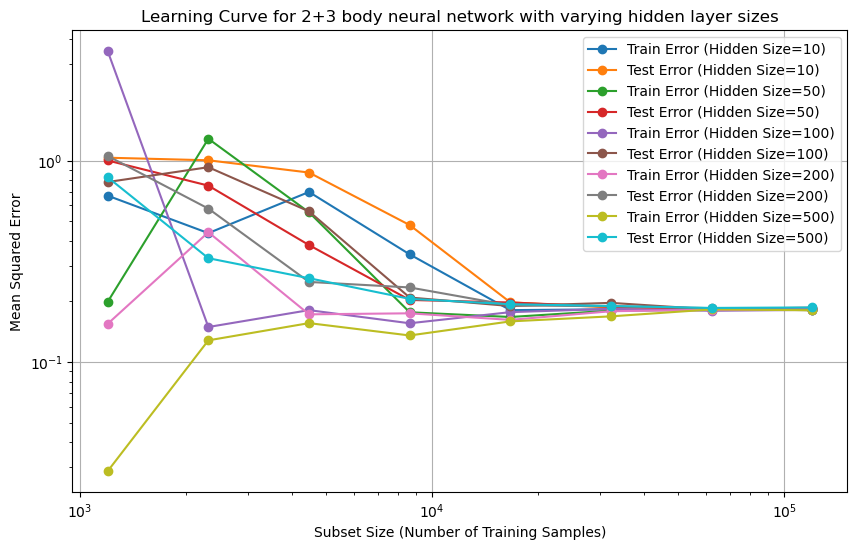

In [8]:
dataset = MyDataset("2-body")
simple_NN_graph(dataset)